In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

2024-05-07 21:02:06.580629: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 21:02:06.659404: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 21:02:07.153588: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 21:02:09.559271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Task 1

In [2]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder 

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below: 

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [5]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):

    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term =  0.5 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1)

    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [188]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(original_dim,))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 256)       │    200,960 │ input_layer_40[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 256)       │     65,792 │ dense_44[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        514 │ dense_45[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        514 │ dense_45[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_8          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 267,780 (1.02 MB)

 Trainable params: 267,780 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [189]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 514)

## d)

In [190]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,048 (1.02 MB)

 Trainable params: 268,048 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

## e)

In [191]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [192]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 230.3116 - total_loss: 193.3568
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 165.5591 - total_loss: 163.5851
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 158.0149 - total_loss: 157.3376
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 153.8721 - total_loss: 153.4518
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 150.7664 - total_loss: 150.8796
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 148.6160 - total_loss: 148.8257
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 147.1926 - total_loss: 147.3077
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 145.9108 - total_loss: 145.9576
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 144.8207 - total_loss: 145.0128
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 143.7283 - total_loss: 144.1913


## f)

In [193]:
# representation in the latent space of observations from test ds
z_test_pred = encoder.predict(x_test) # encoder predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [194]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = decoder.predict(z_test_pred[2]) # decoder predictions - we take a vector from the latent space and transform it to be again a picture

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [195]:
import matplotlib.pyplot as plt
import seaborn as sns

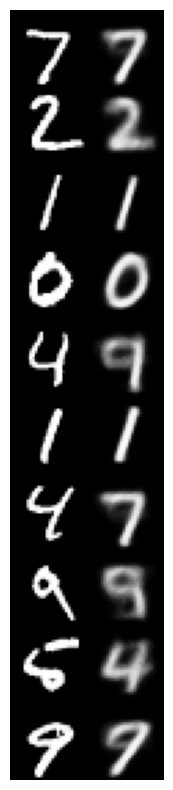

In [196]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [17]:
# use z_test_pred

In [18]:
from sklearn.manifold import TSNE

In [19]:
tsne = TSNE(n_components=2)

In [20]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred[0])

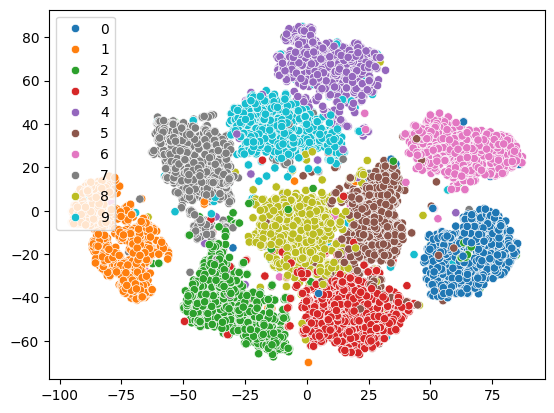

In [21]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

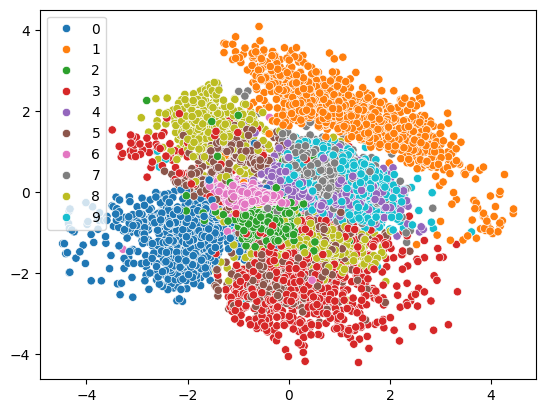

In [197]:
N=10000
sns.scatterplot(x=z_test_pred[0][:N,0], y=z_test_pred[0][:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

<Axes: >

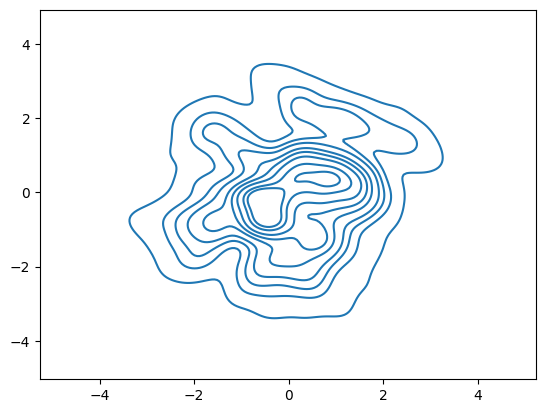

In [198]:
sns.kdeplot(x=z_test_pred[0][:,0], y=z_test_pred[0][:,1])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


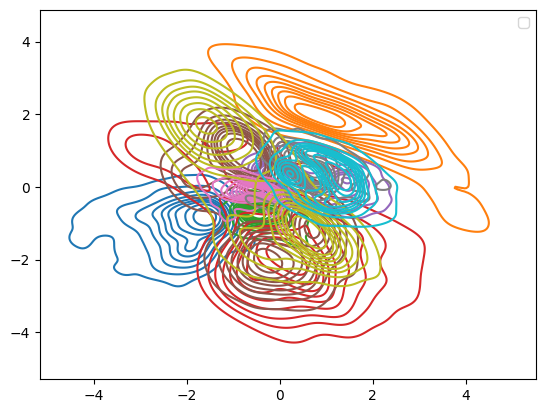

In [199]:
for number in range(10):
    number_cases = z_test_pred[0][y_test==number]
    sns.kdeplot(x=number_cases[:,0], y=number_cases[:,1])

# h)

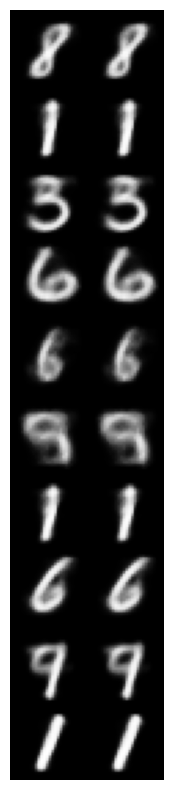

In [201]:
z_new = tf.random.normal(shape=(10,latent_dim))
x_new = decoder(z_new)
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = np.array(x_new)

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = decoded[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

# 3

In [219]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim,))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")


latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")


vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 223.8898 - total_loss: 180.5829
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 139.0358 - total_loss: 134.9622
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 125.7529 - total_loss: 124.1995
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 119.2818 - total_loss: 118.8724
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 115.9419 - total_loss: 115.7470
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 113.6439 - total_loss: 113.6060
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 111.9110 - total_loss: 111.9562
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 110.6936 - total_loss: 110.7782
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 109.7404 - total_loss: 109.6620
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 108.6089 - total_loss: 108.8229


## steps from one digit to another (start to end)

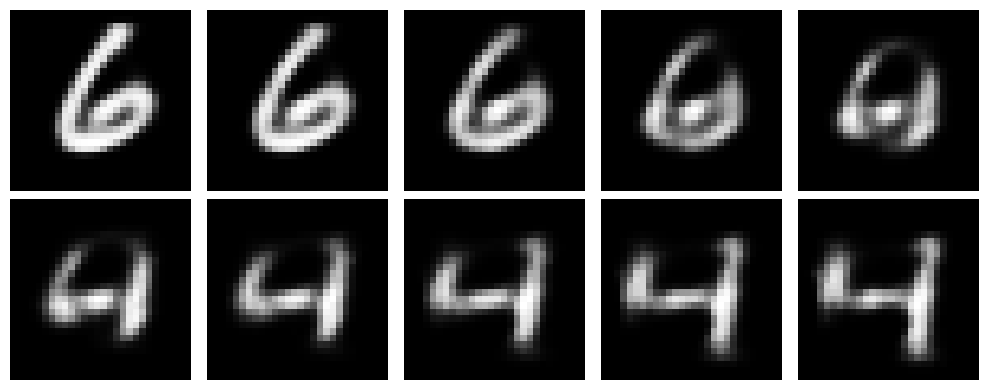

In [223]:
start = 6
end = 4

start_idx = np.argwhere(y_train==start)[0]
x_start = x_train[start_idx]
z_start = encoder(x_start)[0]
end_idx = np.argwhere(y_train==end)[0]
x_end = x_train[end_idx]
z_end = encoder(x_end)[0]

steps = []
for z in np.linspace(z_start, z_end, 10):
    x_new = decoder(z)
    steps.append(x_new.numpy().reshape(28, 28))



fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()

for i, step in enumerate(steps):
    axes[i].imshow(step, cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# 2

In [176]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim,))
class_input = keras.Input(shape=(10,))
x = keras.layers.Concatenate(axis=-1)([encoder_inputs, class_input])
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model([encoder_inputs, class_input], [z_mean, z_log_var, z], name="cencoder")
encoder.summary()

Model: "cencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_37      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 794)       │          0 │ input_layer_36[0… │
│ (Concatenate)       │                   │            │ input_layer_37[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 256)       │    203,520 │ concatenate_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 256)       │     65,792 │ dense_39[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 10)        │      2,570 │ dense_40[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 10)        │      2,570 │ dense_40[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_7          │ (None, 10)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 274,452 (1.05 MB)

 Trainable params: 274,452 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [177]:
latent_inputs = keras.Input(shape=(latent_dim,))
class_input = keras.Input(shape=(10,))
x = keras.layers.Concatenate(axis=-1)([latent_inputs, class_input])
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model((latent_inputs, class_input), decoder_outputs, name="cdecoder")
decoder.summary()

Model: "cdecoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_39      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 20)        │          0 │ input_layer_38[0… │
│ (Concatenate)       │                   │            │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 256)       │      5,376 │ concatenate_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 256)       │     65,792 │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 784)       │    201,488 │ dense_42[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 272,656 (1.04 MB)

 Trainable params: 272,656 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [178]:
class cVAE(keras.Model):
    def __init__(self, cencoder, cdecoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = cencoder
        self.decoder = cdecoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            y = data[0][1]
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder((z, y))

            total_loss = -elbo_vae(data[0][0], reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}   

In [179]:
one_hot_y_train = to_categorical(y_train)

In [180]:
cvae = cVAE(encoder, decoder)
cvae.compile(optimizer=keras.optimizers.Adam())
cvae.fit((x_train, one_hot_y_train), epochs=10, batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 217.6219 - total_loss: 172.4795
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 130.9134 - total_loss: 127.6825
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 119.3922 - total_loss: 118.0427
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 113.9864 - total_loss: 113.1636
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 110.5887 - total_loss: 109.9357
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 107.8287 - total_loss: 107.8050
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 106.2508 - total_loss: 106.0911
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 104.7283 - total_loss: 104.7761
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 103.6913 - total_loss: 103.7511
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 102.7937 - total_loss: 102.8026


In [181]:
one_hot_y_test = to_categorical(y_test)
z_test_pred = encoder.predict((x_test, one_hot_y_test)) # encoder predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [182]:
test_pred = decoder.predict((z_test_pred[2], one_hot_y_test))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


## deconstruction

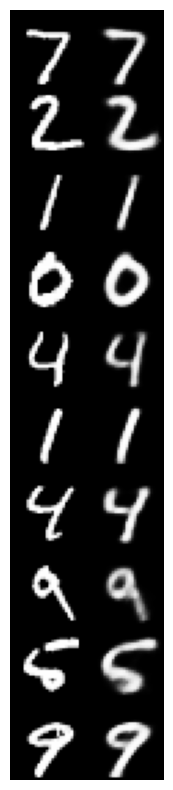

In [183]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## Latent space (classes are mixed)

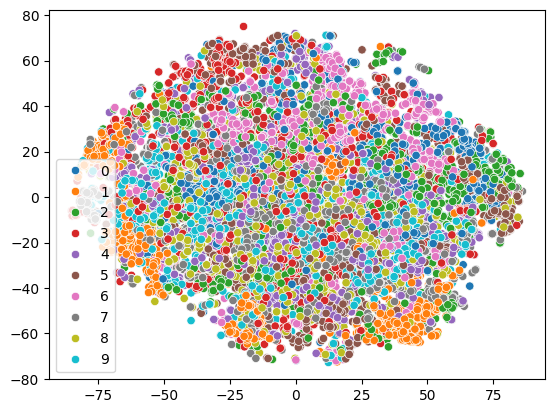

In [184]:
tsne = TSNE(n_components=2)
z_test_pred_tsne = tsne.fit_transform(z_test_pred[0])
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

## New images

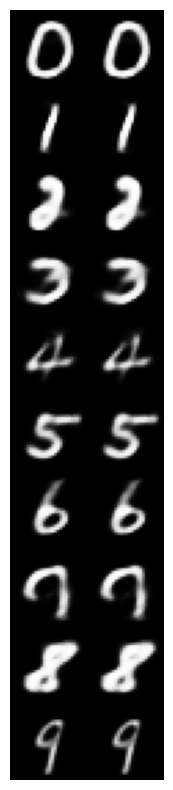

In [185]:
z_new = tf.random.normal(shape=(10,latent_dim))
y_new = tf.convert_to_tensor(to_categorical(range(10)))
x_new = decoder((z_new, y_new))
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = np.array(x_new)

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = decoded[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

## Different numbers from the same latent point

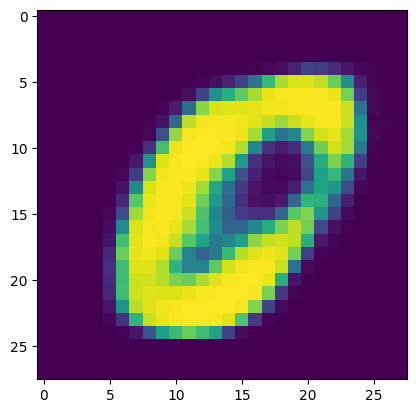

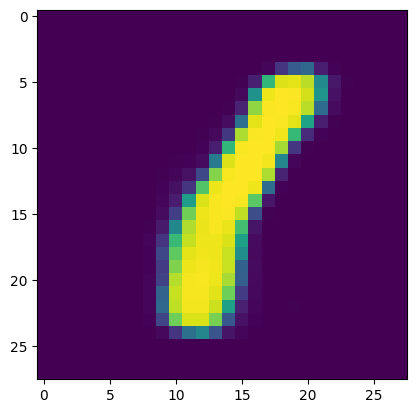

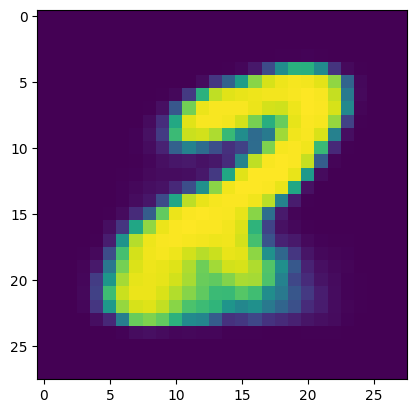

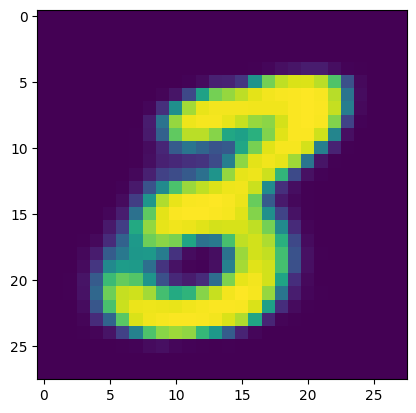

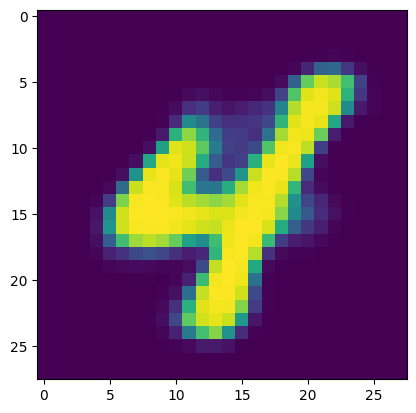

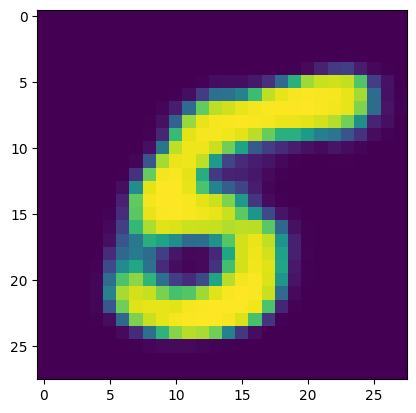

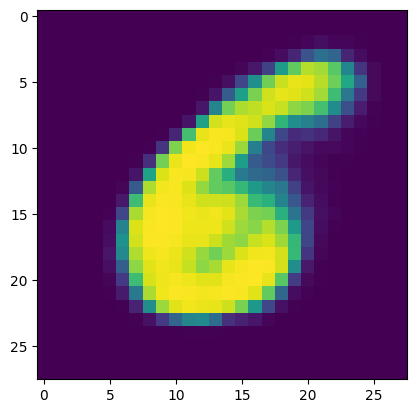

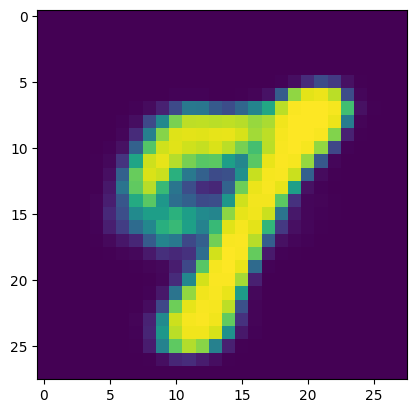

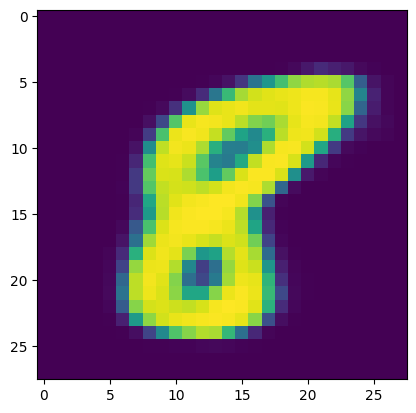

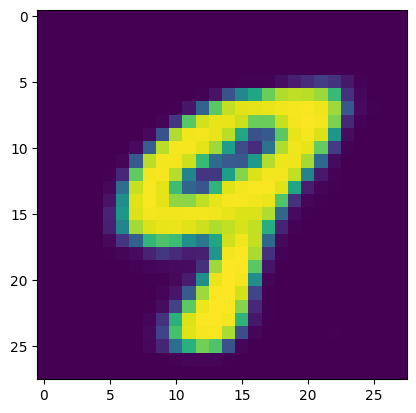

In [187]:
z_new = tf.reshape(tf.random.normal(shape=(latent_dim,)), (1, -1))
for i in range(10):
    y_new = tf.reshape(tf.convert_to_tensor(to_categorical(i, num_classes=10)), (1, -1))
    x_new = decoder((z_new, y_new))
    plt.imshow(x_new.numpy().reshape(-1, 28))
    plt.show()